In [1]:
import numpy as np
import copy
import os
import pickle
import torch
from torch.autograd import Variable

'''
PyTorch does not the same abstract API Keras does for optimization, in particular
while it does contain an array of advanced first order methods like e.g., RMSprop
one needs to construct one's own looping structure in order to employ it properly. 
Below the class My_Opt does just this.  
'''
class My_Opt:
    def __init__(self,model,cost):
        self.model = model
        self.cost = cost
        learning_rate = 10**(-2)
        self.optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
        
        # record history
        self.cost_history = []
        self.weight_history = []
        
    def fit(self,x,y,beta,max_its,lr):
        # update learning rate
        self.optimizer.param_groups[0]['lr'] = lr
        
        for t in range(max_its):
            # Forward pass: compute predicted y by passing x to the model.
            y_pred = self.model(x.float())

            # Compute and print loss value
            # weight each point differently given beta
            cost_val = 0
            for i in range(len(beta)):
                inp = y_pred[i]
                inp = inp.view(1,len(inp)).double()
                out = y[i]
                out = out.view(1,).long()
                bet = beta[i]     
                cost_val += bet*self.cost(inp,out)
            self.optimizer.zero_grad()

            if len(self.cost_history) == 0 or t > 0:
                # store weight and cost history
                self.cost_history.append(cost_val.data.item())
                self.weight_history.append(self.optimizer.param_groups[0]['params'])

            # Backward pass: compute gradient of the loss with respect to model
            # parameters
            cost_val.backward()

            # Calling the step function on an Optimizer makes an update to its
            # parameters
            self.optimizer.step()

        # collect last input / weights
        y_pred = self.model(x.float())
        cost_val = 0
        for i in range(len(beta)):
            inp = y_pred[i]
            inp = inp.view(1,len(inp)).double()
            out = y[i]
            out = out.view(1,).long()
            bet = beta[i]     
            cost_val += bet*self.cost(inp,out)
                
        self.cost_history.append(cost_val.data.item())
        self.weight_history.append(self.optimizer.param_groups[0]['params'])

class PG():
    # load in simulator, initialize global variables
    def __init__(self,simulator,savename,**kwargs):
        # make simulator global
        self.simulator = simulator
        
        # PG learn params
        self.explore_val = 1
        self.explore_decay = 0.99
        self.num_episodes = 500        
        self.gamma = 1
        
        if "gamma" in kwargs:   
            self.gamma = args['gamma']
        if 'explore_val' in kwargs:
            self.explore_val = kwargs['explore_val']
        if 'explore_decay' in kwargs:
            self.explore_decay = kwargs['explore_decay']
        if 'num_episodes' in kwargs:
            self.num_episodes = kwargs['num_episodes']
            
        # other training variables
        self.num_actions = self.simulator.action_space.n
        state = self.simulator.reset()    
        self.state_dim = np.size(state)
        self.training_reward = []
        
        # setup memory params
        self.memory_length = 10     # length of memory replay (in episodes)
        self.episode_update = 1     # when to update (in episodes)
        self.memory = []
        if 'memory_length' in kwargs:
            self.memory_length = kwargs['memory_length']
        if 'episode_update' in kwargs:
            self.episode_update = kwargs['episode_update']
            
        ### initialize logs ###
        # create text file for training log
        self.logname = 'training_logs/' + savename + '.txt'
        self.reward_logname = 'reward_logs/' + savename + '.txt'
        self.weight_name = 'saved_model_weights/' + savename + '.pkl' 
        self.model_name = 'models/' + savename + '.json'

        self.init_log(self.logname)
        self.init_log(self.reward_logname)
        self.init_log(self.weight_name)
        self.init_log(self.model_name)
     
    ##### logging functions #####
    def init_log(self,logname):
        # delete log if old version exists
        if os.path.exists(logname): 
            os.remove(logname)
            
    def update_log(self,logname,update):
        if type(update) == str:
            logfile = open(logname, "a")
            logfile.write(update)
            logfile.close() 
        else:
            weights = []
            if os.path.exists(logname):
                with open(logname,'rb') as rfp: 
                    weights = pickle.load(rfp)
            weights.append(update)

            with open(logname,'wb') as wfp:
                pickle.dump(weights, wfp)
    
    ##### functions for creating / updating Q #####
    def initialize_Q(self,**kwargs):
        # default parameters for network
        layer_sizes = [10,10]      # two hidden layers, 10 units each, by default
        activation = 'relu'
        if 'layer_sizes' in kwargs:
            layer_sizes = kwargs['layer_sizes']
        if 'activation' in kwargs:
            activation = kwargs['activation']

        # default parameters for optimizer - reset by hand
        self.lr = 10**(-2)
        if 'alpha' in kwargs:
            self.lr = kwargs['alpha']

        # input / output sizes of network
        input_dim = self.state_dim
        output_dim = self.num_actions

        # Use the nn package to define our model and loss function
        self.model = torch.nn.Sequential()

        # add input layer
        self.model.add_module('linear ' + str(0),torch.nn.Linear(input_dim,layer_sizes[0]))
        if activation == 'relu':
            self.model.add_module('activation ' + str(0),torch.nn.ReLU())
        if activation == 'tanh':
            self.model.add_module('activation ' + str(0),torch.nn.Tanh())

        # add hidden layers
        for i in range(1,len(layer_sizes)):
            U = layer_sizes[i-1]
            V = layer_sizes[i]
            self.model.add_module('linear ' + str(i),torch.nn.Linear(U,V))
            if activation == 'relu':
                self.model.add_module('activation ' + str(i),torch.nn.ReLU())
            if activation == 'tanh':
                self.model.add_module('activation ' + str(i),torch.nn.Tanh())

        # add output layer
        self.model.add_module('linear ' + str(len(layer_sizes)),torch.nn.Linear(layer_sizes[-1], output_dim))
                
        # define cost function
        self.cost = torch.nn.CrossEntropyLoss(size_average=True)
        
        # setup optimizer - using hand-made optimizer class + RMSprop
        self.opt = My_Opt(self.model,self.cost)

        # initialize Q
        self.Q = self.opt.model.forward
        
    # compute long term rewards for weighted gradient descent steps
    def create_weights(self,episode_data):
        # create long term reward simulator
        rewards = []
        for j in range(len(episode_data)):
            sample = episode_data[j]
            reward = sample[3]
            rewards.append(reward)

        # build long term rewards for each step
        beta = np.zeros_like(np.array(rewards))
        longterm_reward = 0
        for t in reversed(range(len(rewards))):
            longterm_reward = rewards[t] + self.gamma*longterm_reward
            beta[t] = longterm_reward
        return beta
    
    # update Q function
    def update_control(self):        
        # generate q_values based on most recent Q
        a_vals = []
        states = []
        for i in range(len(self.memory)):    
            # get episode_data
            episode_data = self.memory[i]
            
            # create long-term rewards (weights for gradient descent step)
            beta = self.create_weights(episode_data)
            
            # create input/output data for gradient descent step
            s_in = []
            a_vals = []
            for j in range(len(episode_data)):
                # get next sample of episode
                sample = episode_data[j]
                state = sample[0]
                action = sample[2]
                
                # strip sample for parts
                s_in.append(state.T)
                a_vals.append(action)

            # convert lists to torch tensors classifier
            s_in = np.array(s_in).T
            s_in = s_in[0,:,:]
            s_in = torch.from_numpy(s_in)
            s_in = Variable(s_in,requires_grad = False)
            
            a_vals = np.array(a_vals)
            a_vals = torch.from_numpy(a_vals)
            a_vals = Variable(a_vals,requires_grad = False)
        
            beta = np.array(beta).T
            beta = torch.from_numpy(beta)
            beta = Variable(beta,requires_grad = False)
            
            # take descent step
            self.opt.fit(s_in.t(),a_vals,beta,max_its = 1,lr=self.lr)

        # update Q based on regressor updates
        self.Q = self.opt.model.forward
        
    ##### functions for adjusting replay memory #####
    # update memory - add sample to list, remove oldest samples 
    def update_memory(self,episode_data):
        # add most recent trial data to memory
        self.memory.append(episode_data)

        # clip memory if it gets too long    
        num_episodes = len(self.memory)
        if num_episodes >= self.memory_length:    
            num_delete = num_episodes - self.memory_length
            self.memory[:num_delete] = []
    
    ##### PG Learning functionality #####    
    # state normalizer
    def state_normalizer(self,states):
        states = np.array(states)[np.newaxis,:]
        return states
    
    # choose next action
    def choose_action(self,state):
        # pick action at random
        p = np.random.rand(1)   
        action = np.random.randint(self.num_actions)
            
        # pick action based on exploiting - after memory full
        state = Variable(torch.from_numpy(state),requires_grad=False)        
        qs = self.Q(state.float()).detach().numpy()
        if p > self.explore_val:
            action = np.argmax(qs)
        return action
    
    # main training function
    def train(self,**kwargs):
        ### start main PG loop ###
        for n in range(self.num_episodes): 
            # pick this episode's starting position - randomly initialize from f_system
            state = self.simulator.reset()    
            state = self.state_normalizer(state)
            total_episode_reward = 0
            done = False
            
            # get out exploit parameter for this episode
            if self.explore_val > 0.01:
                self.explore_val *= self.explore_decay
                    
            # run episode
            step = 0
            episode_data = []
            while done == False and step < 500:    
                # choose next action
                action = self.choose_action(state) 
    
                # transition to next state, get associated reward
                next_state,reward,done,info = self.simulator.step(action)  
                next_state = self.state_normalizer(next_state)

                # store data for transition after episode ends
                episode_data.append([state,next_state,action,reward,done])

                # update total reward from this episode
                total_episode_reward+=reward
                state = copy.deepcopy(next_state)
                step += 1
                  
            # update memory with this episode's data
            self.update_memory(episode_data)
            
            # update Q function
            if np.mod(n,self.episode_update) == 0:
                self.update_control()  
                  
            ### print out updates ###
            update = 'training episode ' + str(n+1) +  ' of ' + str(self.num_episodes) + ' complete, ' +  ' explore val = ' + str(np.round(self.explore_val,3)) + ', episode reward = ' + str(np.round(total_episode_reward,2)) 

            self.update_log(self.logname,update + '\n')
            print (update)

            update = str(total_episode_reward) + '\n'
            self.update_log(self.reward_logname,update)

            ### store this episode's computation time and training reward history
            self.training_reward.append(total_episode_reward)

            # save latest weights from this episode 
            update = self.opt.weight_history[-1]
            self.update_log(self.weight_name,update)
                            
        ### save weights ###
        update = 'q-learning algorithm complete'
        self.update_log(self.logname,update + '\n')
        print (update)

# Run test

In [2]:
# imports
import gym

# savename
savename = 'cartpole_experiment_1'

# initialize simulator
simulator = gym.make('CartPole-v1') 

# initialize PG Learn process
num_episodes = 500
explore_decay = 0.995
explore_val = 1

# initialize memory
episode_update = 1
memory_length = 10

# load into instance of learner
demo = PG(simulator,savename,num_episodes=num_episodes,explore_decay=explore_decay,explore_val=explore_val,memory_length=memory_length,episode_update=episode_update)

# initialize Q function
layer_sizes = [100]
alpha = 10**(-2)
activation = 'relu'
demo.initialize_Q(layer_sizes=layer_sizes,alpha=alpha,activation=activation)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [3]:
demo.train()

training episode 1 of 500 complete,  explore val = 0.995, episode reward = 13.0
training episode 2 of 500 complete,  explore val = 0.99, episode reward = 28.0
training episode 3 of 500 complete,  explore val = 0.985, episode reward = 27.0
training episode 4 of 500 complete,  explore val = 0.98, episode reward = 11.0
training episode 5 of 500 complete,  explore val = 0.975, episode reward = 21.0
training episode 6 of 500 complete,  explore val = 0.97, episode reward = 20.0
training episode 7 of 500 complete,  explore val = 0.966, episode reward = 17.0
training episode 8 of 500 complete,  explore val = 0.961, episode reward = 14.0
training episode 9 of 500 complete,  explore val = 0.956, episode reward = 15.0
training episode 10 of 500 complete,  explore val = 0.951, episode reward = 18.0
training episode 11 of 500 complete,  explore val = 0.946, episode reward = 10.0
training episode 12 of 500 complete,  explore val = 0.942, episode reward = 19.0
training episode 13 of 500 complete,  ex

KeyboardInterrupt: 

# plot total episode reward history

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def plot_reward_history(logname,**kwargs):
    # load in total episode reward history
    data = np.loadtxt(logname)
    ave = [data[v] for v in range(100)]
    ""
    for i in range(0,np.size(data)-100):
        m = np.mean(data[i:i+100])
        ave.append(m)
    
    # create figure
    fig = plt.figure(figsize = (12,8))
    ax1 = fig.add_subplot(2,1,1)
    ax2 = fig.add_subplot(2,1,2)

    # plot total reward history
    start = 0
    if 'start' in kwargs:
        start = kwargs['start']
    ax1.plot(data[start:])
    ax1.set_xlabel('episode',labelpad = 8,fontsize = 13)
    ax1.set_ylabel('total reward',fontsize = 13)
    
    ax2.plot(ave[start:],linewidth=3)
    ax2.set_xlabel('episode',labelpad = 8,fontsize = 13)
    ax2.set_ylabel('ave total reward',fontsize=13)
    plt.show()

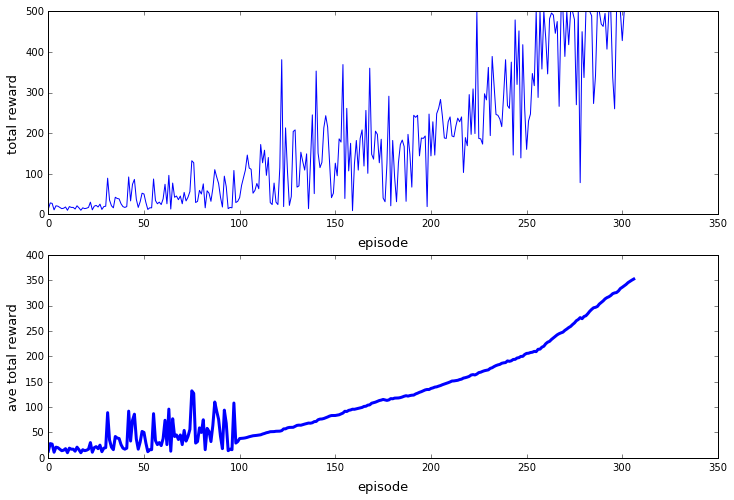

In [5]:
reward_logname = 'reward_logs/' + savename + '.txt'
plot_reward_history(reward_logname)